In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, log_loss
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import re
from sqlalchemy import create_engine
from imblearn.under_sampling import RandomUnderSampler

# Database connection setup
db_config = {
    'host': 'localhost',
    'database': 'postgres',
    'user': 'postgres',
    'password': 'kaviyam123',
    'port': '5432'
}

connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
engine = create_engine(connection_string)

# Step 1: Load data from PostgreSQL
query = 'SELECT * FROM public.overall_cleaned_base_and_pr_ef_policyef;'
data = pd.read_sql(query, con=engine)

selected_columns = ['policy no', 'product name', 'product name 2',  'biztype', 'policy end date', 'policy start date', 'renewal type', 'tie up', 'vehicle segment',
 'age', 'manufacturer/make', 'model', 'variant', 'fuel type', 'rto location', 'vehicle idv', 'ncb amount', 'applicable discount without ncb', 
 'before gst add-on gwp', 'total od premium', 'total tp premium', 'gst', 'total premium payable', 
 'ncb % previous year', 'applicable discount with ncb', 'Cleaned Branch Name 2', 'Cleaned State2', 'Cleaned Zone 2', 
 'Number of claims', 'approved', 'denied', 'customerid', 'Policy Status', 'Policy Tenure Month', 'Policy Tenure', 'Customer Tenure', 'New Customers', 'Claim Happaned/Not', 
 'Renewal Rate Status', 'withdrawn', 'Cleaned Chassis Number', 'Cleaned Engine Number', 'Cleaned Reg no', 'corrected_name', 'updated_old_policy_no',
  'new_chain_flag', 'chain_group', 'first_initial_policy_no', 'policy_wise_purchase', 'cleaned new vertical', 'add on eligibilty (5th & 6th renewals with ncb)', 
  'chassis_engine_key', 'current year ncb (amount)', 'oem discount category', 'hyundai discount status', 'last year ncb',
  'detariff disc amount', 'reg year bucket 2'
]

data = data[selected_columns]

# Remove rows where 'Status' contains 'Open'
data = data[data['Policy Status'].isin(['Renewed', 'Not Renewed'])]


data['Policy Status'] = data['Policy Status'].apply(lambda x: 1 if x == 'Not Renewed' else 0)

# Fill missing values
for column in data.columns:
    if data[column].dtype == 'object':
        mode_value = data[column].mode()[0] if not data[column].mode().empty else 'missing'
        data[column] = data[column].fillna(mode_value)
    else:
        mean_value = data[column].mean()
        data[column] = data[column].fillna(mean_value)

date_columns = ['policy start date', 'policy end date']

for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

# Extract year, month, and day as separate features for all date columns
new_date_cols = {}
for col in date_columns:
    new_date_cols[f'{col}_YEAR'] = data[col].dt.year
    new_date_cols[f'{col}_MONTH'] = data[col].dt.month
    new_date_cols[f'{col}_DAY'] = data[col].dt.day

data = pd.concat([data, pd.DataFrame(new_date_cols)], axis=1)

# Drop date columns after splitting
data = data.drop(columns=date_columns)

# Define features and target
features = [col for col in data.columns if col not in ['Policy Status']]

# Define X (features) and y (target)
X = data[features]
y = data['Policy Status']

X_train_uncleaned, X_test, y_train_uncleaned, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [2]:
# Combine the uncleaned training features and target for outlier removal
train_data_uncleaned = pd.concat([X_train_uncleaned, y_train_uncleaned], axis=1)

# Identify numeric columns in the training data
numeric_cols = train_data_uncleaned.select_dtypes(include=[np.number]).columns.tolist()

def remove_outliers_iqr(df, columns, factor=1.5):

    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        
        # Debug: Print number of outliers detected for the column
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        print(f"Column '{col}': Outliers Detected = {outliers.shape[0]}")
        
        # Filter the dataframe to remove outliers for the current column
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Remove outliers from the uncleaned training data using the IQR method
train_data_clean = remove_outliers_iqr(train_data_uncleaned, numeric_cols, factor=1.5)

# Reassign the cleaned training data to X_train and y_train
X_train = train_data_clean.drop(columns=['Policy Status'])
y_train = train_data_clean['Policy Status']

# Optional: Report the shape before and after cleaning
print(f"Original uncleaned training set shape: {train_data_uncleaned.shape}")
print(f"Cleaned training set shape: {train_data_clean.shape}")

Column 'ncb amount': Outliers Detected = 40411
Column 'before gst add-on gwp': Outliers Detected = 4207
Column 'total od premium': Outliers Detected = 46574
Column 'total tp premium': Outliers Detected = 0
Column 'gst': Outliers Detected = 24058
Column 'total premium payable': Outliers Detected = 5367
Column 'Number of claims': Outliers Detected = 135676
Column 'approved': Outliers Detected = 0
Column 'denied': Outliers Detected = 0
Column 'Policy Tenure Month': Outliers Detected = 30905
Column 'Policy Tenure': Outliers Detected = 0
Column 'Customer Tenure': Outliers Detected = 87548
Column 'withdrawn': Outliers Detected = 0
Column 'new_chain_flag': Outliers Detected = 154918
Column 'chain_group': Outliers Detected = 33686
Column 'policy_wise_purchase': Outliers Detected = 0
Column 'current year ncb (amount)': Outliers Detected = 5670
Column 'last year ncb': Outliers Detected = 101
Column 'detariff disc amount': Outliers Detected = 7
Column 'policy start date_YEAR': Outliers Detected =

In [3]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, log_loss, roc_curve
import matplotlib.pyplot as plt

# Initialize RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Apply Random Oversampling to the training data
X_train, y_train = ros.fit_resample(X_train, y_train)

In [3]:
# Apply label encoding to categorical features for both train and test sets
for column in X_train.columns:
    if X_train[column].dtype == 'object':
        # Initialize and fit the LabelEncoder on the training data
        label_encoder = LabelEncoder()
        X_train[column] = label_encoder.fit_transform(X_train[column].astype(str))

        # Create a mapping dictionary from the LabelEncoder
        mapping_dict = {label: i for i, label in enumerate(label_encoder.classes_)}
        
        # Track the next unique integer for unseen values in the test set
        next_unique_value = [max(mapping_dict.values()) + 1]  

        # Encode the test data
        def encode_test_value(value):
            if value in mapping_dict:
                return mapping_dict[value]
            else:
                # Update the mapping_dict with a new unique value for unseen categories
                mapping_dict[value] = next_unique_value[0]
                next_unique_value[0] += 1
                return mapping_dict[value]

        # Apply the encoding to the test set
        X_test[column] = X_test[column].apply(encode_test_value)

In [ ]:
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# Initialize tree-based classifiers
clf_dt = DecisionTreeClassifier(random_state=42)
clf_rf = RandomForestClassifier(random_state=42)
clf_et = ExtraTreesClassifier(random_state=42)
clf_gb = GradientBoostingClassifier(random_state=42)

# Create the VotingClassifier with soft voting (averaging probabilities)
model = VotingClassifier(
    estimators=[('dt', clf_dt), ('rf', clf_rf), ('et', clf_et), ('gb', clf_gb)],
    voting='soft'
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7152889359054966
Test Log Loss: 0.5421055710808076
Test ROC AUC: 0.7780736451769265
Test Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.47      0.55    111075
           1       0.73      0.86      0.79    189528

    accuracy                           0.72    300603
   macro avg       0.70      0.66      0.67    300603
weighted avg       0.71      0.72      0.70    300603

Class 0 Test Accuracy: 0.47060994823317576
Class 1 Test Accuracy: 0.8586857878519268
Train Accuracy: 0.7394640310887866
Train Log Loss: 0.5025879895162065
Train ROC AUC: 0.8064959554504018
Train Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.52      0.59    223778
           1       0.77      0.86      0.81    409505

    accuracy                           0.74    633283
   macro avg       0.72      0.69      0.70    633283
weighted avg       0.73      0.74      0.73    633283


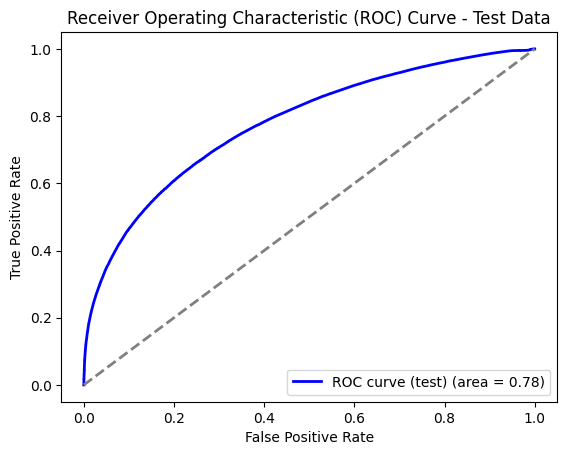

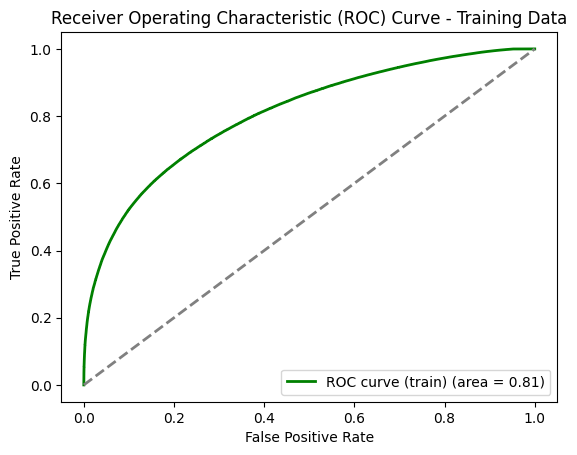

In [4]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import VotingClassifier

# Define three XGBoost models with different parameters
clf_xgb1 = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)

clf_xgb2 = xgb.XGBClassifier(
    max_depth=8,
    learning_rate=0.05,
    n_estimators=150,
    random_state=42
)

clf_xgb3 = xgb.XGBClassifier(
    max_depth=4,
    learning_rate=0.2,
    n_estimators=80,
    random_state=42
)

# Create a VotingClassifier ensemble with soft voting
model = VotingClassifier(
    estimators=[('xgb1', clf_xgb1), ('xgb2', clf_xgb2), ('xgb3', clf_xgb3)],
    voting='soft'
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7185557030368959
Test Log Loss: 0.5407674278366247
Test ROC AUC: 0.7807259905847773
Test Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.58      0.60    111075
           1       0.77      0.80      0.78    189528

    accuracy                           0.72    300603
   macro avg       0.70      0.69      0.69    300603
weighted avg       0.71      0.72      0.72    300603

Class 0 Test Accuracy: 0.582669367544452
Class 1 Test Accuracy: 0.7981934067789456
Train Accuracy: 0.7367606583470581
Train Log Loss: 0.508951704903162
Train ROC AUC: 0.8056530311332121
Train Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.63      0.63    223778
           1       0.80      0.79      0.80    409505

    accuracy                           0.74    633283
   macro avg       0.71      0.71      0.71    633283
weighted avg       0.74      0.74      0.74    633283

Cl

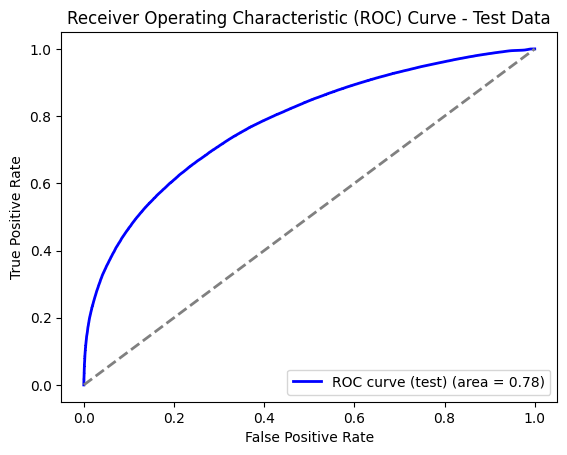

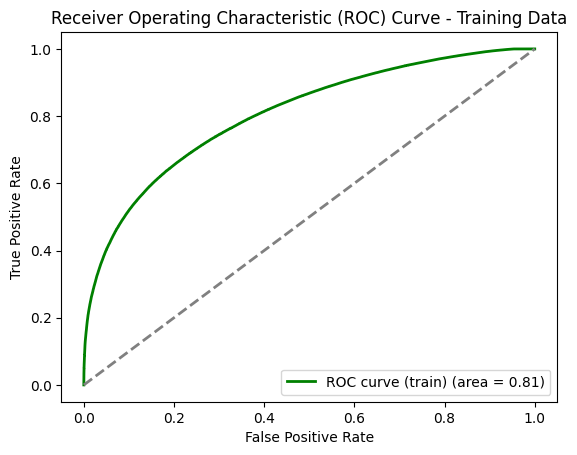

In [5]:
import xgboost as xgb
from sklearn.ensemble import VotingClassifier

# Define three XGBoost models with different parameters
clf_xgb1 = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)

clf_xgb2 = xgb.XGBClassifier(
    max_depth=8,
    learning_rate=0.05,
    n_estimators=150,
    random_state=42
)

clf_xgb3 = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    random_state=42
)

clf_xgb4 = xgb.XGBClassifier(
    max_depth=5,                  
    learning_rate=0.05,            
    n_estimators=200,              
    subsample=0.8,                 
    colsample_bytree=0.8,         
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  
    gamma=0.1,                    
    random_state=42
)

clf_xgb5 = xgb.XGBClassifier(
    max_depth=6,                  
    learning_rate=0.1,            
    n_estimators=100,            
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), 
    random_state=42
)

# Create a VotingClassifier ensemble with soft voting
model = VotingClassifier(
    estimators=[('xgb1', clf_xgb1), ('xgb2', clf_xgb2), ('xgb3', clf_xgb3), ('xgb4', clf_xgb4), ('xgb5', clf_xgb5)],
    voting='soft'
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

In [6]:
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# Define three XGBoost models with different parameters
clf_xgb1 = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)

clf_xgb2 = xgb.XGBClassifier(
    max_depth=8,
    learning_rate=0.05,
    n_estimators=150,
    random_state=42
)

clf_xgb3 = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    random_state=42
)

clf_xgb4 = xgb.XGBClassifier(
    max_depth=5,                  
    learning_rate=0.05,            
    n_estimators=200,              
    subsample=0.8,                 
    colsample_bytree=0.8,         
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  
    gamma=0.1,                    
    random_state=42
)

clf_xgb5 = xgb.XGBClassifier(
    max_depth=6,                  
    learning_rate=0.1,            
    n_estimators=100,            
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), 
    random_state=42
)

# Create a VotingClassifier ensemble with soft voting
model = VotingClassifier(
    estimators=[('xgb1', clf_xgb1), ('xgb2', clf_xgb2), ('xgb3', clf_xgb3), ('xgb4', clf_xgb4), ('xgb5', clf_xgb5)],
    voting='hard'
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data using predict (hard voting only provides class labels)
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# Evaluate the model on test data using metrics that rely on class labels
accuracy_test = accuracy_score(y_test, y_pred_test)
report_test = classification_report(y_test, y_pred_test)

# Evaluate the model on training data
accuracy_train = accuracy_score(y_train, y_pred_train)
report_train = classification_report(y_train, y_pred_train)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test data
print("Test Data Evaluation:")
print(f"Test Accuracy: {accuracy_test}")
print(f"Test Classification Report:\n{report_test}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

# Print evaluation metrics for training data
print("\nTraining Data Evaluation:")
print(f"Train Accuracy: {accuracy_train}")
print(f"Train Classification Report:\n{report_train}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

Test Data Evaluation:
Test Accuracy: 0.7180034796725249
Test Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.55      0.59    111075
           1       0.76      0.82      0.79    189528

    accuracy                           0.72    300603
   macro avg       0.70      0.68      0.69    300603
weighted avg       0.71      0.72      0.71    300603

Class 0 Test Accuracy: 0.5481881611523746
Class 1 Test Accuracy: 0.8175256426491072

Training Data Evaluation:
Train Accuracy: 0.7416905238258409
Train Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.57      0.61    223778
           1       0.78      0.84      0.81    409505

    accuracy                           0.74    633283
   macro avg       0.72      0.70      0.71    633283
weighted avg       0.74      0.74      0.74    633283

Class 0 Train Accuracy: 0.5697253528050121
Class 1 Train Accuracy: 0.8356625682226102
